In [1]:
import pandas as pd
import train

df = pd.read_csv('cleaneddata.csv')
# df

/var/folders/_4/yzd4h3k95051tj7kpg425rk80000gn/T/ipykernel_83264/3936584759.py:4: DtypeWarning: Columns (11,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaneddata.csv')


In [3]:
print("Column 11 name:", df.columns[11])
print("Column 24 name:", df.columns[24])

Column 11 name: DateOfCancel
Column 24 name: cancel_timing


In [39]:
pd.set_option('display.max_columns', None)

print(df.head())

          DateOfOrder   OrderId                     TransactionId  \
0 2019-12-02 20:39:46  11161800  5fff5813ae674809a06e3b1fe5528fcf   
1 2019-12-02 20:39:46  11161801  7c4f0e97356e46669abefe8dc5fb0ff0   
2 2019-12-03 22:29:24  11166739  ee1d1a4a7458414a8bb420111ba0fa8c   
3 2019-12-04 13:27:22  11169532  86497dc4e7434b838a335c439325fb65   
4 2019-12-04 13:27:22  11169533  6054345ad0b14bd297dbdc6372ff1488   

  DateOfService  OrderQty          MenuName  MenuPrice  MenuSubsidy  \
0    2020-01-02         1  Mittagessen (BS)       3.05          0.0   
1    2020-01-03         1  Mittagessen (BS)       3.05          0.0   
2    2020-01-02         1  Mittagessen (BS)       3.05          0.0   
3    2020-01-02         1  Mittagessen (BS)       3.05          0.0   
4    2020-01-03         1  Mittagessen (BS)       3.05          0.0   

       BookingNr       GroupName  CanceledQty DateOfCancel Site SchoolID  \
0  474-136052114  Bad Sassendorf            0          NaN   LP   SCH003   
1  474

In [38]:
# checking if there is still cases remaing wich have Dateofservice before dateoforder

df['DateOfOrder'] = pd.to_datetime(df['DateOfOrder'])
df['DateOfService'] = pd.to_datetime(df['DateOfService'])

filtered_df = df[df['DateOfService'] < df['DateOfOrder'].dt.date]


In [7]:
# checking for missing sites
print(df['Site'].unique())


['LP' 'BK' 'MS']


In [36]:
import numpy as np
from sklearn.metrics import classification_report

# --- 1. CANCELLATION PREDICTION ANALYSIS ---
print("\n--- Step 1: Cancellation Prediction Analysis ---")
print("Goal: Understand the drivers of meal cancellations, especially subsidy impact.")

# Feature selection for cancellation model
# We select features that would be known AT THE TIME OF ORDER
cancel_features = [
    'MenuPrice', 'MenuSubsidy', 'subsidy_pct', 'day_of_year', 'weekday',
    'is_weekend', 'sin_doy', 'cos_doy', 'month', 'quarter', 'is_month_end',
    'is_month_start', 'order_hour', 'morning', 'afternoon', 'evening',
    'hist_cancel_rate', 'is_holiday'
]
target_cancel = 'is_canceled'

X_cancel = df[cancel_features].copy() # Use .copy() to avoid SettingWithCopyWarning
y_cancel = df[target_cancel]

# *** FIX: Handle potential missing values before training ***
# RandomForest does not handle NaNs or infinity. We apply a robust, type-aware imputation.
print("Imputing missing and infinite values...")
# Replace infinite values with NaN so they can be imputed by the next steps.
X_cancel.replace([np.inf, -np.inf], np.nan, inplace=True)

# First, forward-fill and back-fill to propagate existing values.
X_cancel = X_cancel.ffill().bfill()

# For any remaining NaNs, fill based on column type.
for col in X_cancel.columns:
    if X_cancel[col].isnull().any():
        if pd.api.types.is_numeric_dtype(X_cancel[col]):
            # Fill remaining numeric NaNs with 0
            X_cancel[col] = X_cancel[col].fillna(0)
        else:
            # Fill remaining categorical/object NaNs with the mode
            mode_val = X_cancel[col].mode()[0]
            X_cancel[col] = X_cancel[col].fillna(mode_val)


# Best Practice: Time Series Split
# For classification on time-ordered data, we split based on time.
# We'll train on the first 80% of the data and test on the most recent 20%.
split_index = int(len(df) * 0.8)
X_train_c, X_test_c = X_cancel[:split_index], X_cancel[split_index:]
y_train_c, y_test_c = y_cancel[:split_index], y_cancel[split_index:]

print(f"Cancellation Train/Test Split: {len(X_train_c)} train rows, {len(X_test_c)} test rows.")

# Model Training: RandomForestClassifier
# We use class_weight='balanced' to handle potential class imbalance.
# This tells the model to weigh the minority class (cancellations) higher.
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1 # Use all available cores
)
print("Training cancellation classifier...")
rf_classifier.fit(X_train_c, y_train_c)

# Evaluation
print("\nEvaluating cancellation classifier...")
y_pred_c = rf_classifier.predict(X_test_c)
print("Classification Report:")
print(classification_report(y_test_c, y_pred_c))

# Feature Importance
print("\nFeature Importances for Cancellation Prediction:")
feature_importances = pd.DataFrame({
    'feature': cancel_features,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importances)

# Conclusion for this step
print("\nInsight: The feature importance list shows how much each factor contributes to predicting a cancellation.")
print("A high importance for 'subsidy_pct' or 'MenuSubsidy' quantifies its effect, as requested.")
print("\n--- End of Step 1 ---")



--- Step 1: Cancellation Prediction Analysis ---
Goal: Understand the drivers of meal cancellations, especially subsidy impact.
Imputing missing and infinite values...
Cancellation Train/Test Split: 3973436 train rows, 993360 test rows.
Training cancellation classifier...

Evaluating cancellation classifier...
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    973468
           1       0.02      0.00      0.01     19892

    accuracy                           0.97    993360
   macro avg       0.50      0.50      0.50    993360
weighted avg       0.96      0.97      0.97    993360


Feature Importances for Cancellation Prediction:
             feature  importance
16  hist_cancel_rate    0.289575
12        order_hour    0.176748
3        day_of_year    0.144873
0          MenuPrice    0.099545
1        MenuSubsidy    0.094246
4            weekday    0.055283
2        subsidy_pct    0.052495
8              month   

In [40]:

# --- 2. DATA PREPARATION FOR FORECASTING ---
print("\n--- Step 2: Data Preparation for Forecasting ---")
print("Goal: Aggregate data and create target variables for future meal counts.")

# Aggregate data to Site-Day level
# We sum the 'net_qty' for each Site on each 'DateOfService'
daily_demand = df.groupby(['DateOfService', 'Site'], observed=False)['net_qty'].sum().reset_index()


# Pivot to have sites as columns, making it easier to process per site
pivot_demand = daily_demand.pivot(index='DateOfService', columns='Site', values='net_qty').fillna(0)

# Create a full date range to ensure no gaps
full_date_range = pd.date_range(start=pivot_demand.index.min(), end=pivot_demand.index.max(), freq='D')
pivot_demand = pivot_demand.reindex(full_date_range, fill_value=0)

print("Pivoted daily demand data:")
print(pivot_demand.head())
pivot_demand
# Feature Engineering for the forecasting model
# We create time-based features on our complete daily index
time_features = pd.DataFrame(index=pivot_demand.index)
time_features['day_of_year'] = time_features.index.dayofyear
time_features['weekday'] = time_features.index.weekday
time_features['is_weekend'] = time_features.index.weekday >= 5
time_features['month'] = time_features.index.month
time_features['quarter'] = time_features.index.quarter
time_features['day_of_month'] = time_features.index.day
time_features['sin_doy'] = np.sin(2 * np.pi * time_features['day_of_year'] / 365.25)
time_features['cos_doy'] = np.cos(2 * np.pi * time_features['day_of_year'] / 365.25)
# Add holiday info if available for the date range
# For this example, we'll simulate it
time_features['is_holiday'] = np.random.choice([0, 1], size=len(time_features), p=[0.97, 0.03])
# todo


# Create lagged features and rolling means (important for time series)
for lag in [1, 2, 3, 7, 14]:
    time_features[f'lag_{lag}'] = pivot_demand.shift(lag).mean(axis=1) # Mean demand across all sites 'lag' days ago

time_features['rolling_mean_7'] = time_features['lag_1'].rolling(window=7).mean()
time_features['rolling_mean_14'] = time_features['lag_1'].rolling(window=14).mean()
time_features = time_features.fillna(0)


# Create Target Variables for each horizon
# To predict the future, the target 'y' must be shifted from the future to the current row.
print("\nCreating target variables for different forecast horizons...")

# Horizon 1: <= 1 day (predicting tomorrow's total for each site)
targets_1_day = pivot_demand.shift(-1)

# Horizon 2: 2-5 days (predicting the average demand for days t+2 to t+5 for each site)
targets_2_5_days = pivot_demand.rolling(window=4, min_periods=1).mean().shift(-5)

# Horizon 3: > 5 days (predicting the average demand for days t+6 to t+10 for each site)
targets_6_10_days = pivot_demand.rolling(window=5, min_periods=1).mean().shift(-10)

print("Target variables created.")
print("\n--- End of Step 2 ---")



--- Step 2: Data Preparation for Forecasting ---
Goal: Aggregate data and create target variables for future meal counts.
Pivoted daily demand data:
Site        BK   LP  MS
2020-01-02  32  169   0
2020-01-03  32  184   0
2020-01-04   0    1   0
2020-01-05   0    0   0
2020-01-06  50  696   0

Creating target variables for different forecast horizons...
Target variables created.

--- End of Step 2 ---


In [41]:
pivot_demand

Site,BK,LP,MS
2020-01-02,32,169,0
2020-01-03,32,184,0
2020-01-04,0,1,0
2020-01-05,0,0,0
2020-01-06,50,696,0
...,...,...,...
2023-12-18,6992,3669,2929
2023-12-19,3863,961,2993
2023-12-20,3544,1296,2689
2023-12-21,83,280,1640


In [42]:
time_features

,day_of_year,weekday,is_weekend,month,quarter,day_of_month,sin_doy,cos_doy,is_holiday,lag_1,lag_2,lag_3,lag_7,lag_14,rolling_mean_7,rolling_mean_14
2020-01-02,2,3,False,1,1,2,0.034398,0.999408,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,3,4,False,1,1,3,0.051584,0.998669,0,67.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-04,4,5,True,1,1,4,0.068755,0.997634,0,72.000000,67.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-05,5,6,True,1,1,5,0.085906,0.996303,0,0.333333,72.000000,67.000000,0.000000,0.000000,0.000000,0.000000
2020-01-06,6,0,False,1,1,6,0.103031,0.994678,0,0.000000,0.333333,72.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-18,352,0,False,12,4,18,-0.225964,0.974136,0,0.000000,0.333333,1905.000000,4722.333333,4511.333333,2638.714286,2645.976190
2023-12-19,353,1,False,12,4,19,-0.209174,0.977879,0,4530.000000,0.000000,0.333333,2716.666667,2811.333333,2611.238095,2647.309524
2023-12-20,354,2,False,12,4,20,-0.192322,0.981332,0,2605.666667,4530.000000,0.000000,4558.333333,4540.000000,2595.380952,2632.619048
2023-12-21,355,3,False,12,4,21,-0.175413,0.984495,0,2509.666667,2605.666667,4530.000000,4568.333333,4775.333333,2302.714286,2487.595238


In [44]:
from sklearn.ensemble import RandomForestRegressor

# --- 3. & 4. TIME SERIES SPLITTING & MODELING PER SITE ---
print("\n--- Steps 3 & 4: Time Series Splitting & Modeling Per Site ---")
print("Goal: Train a separate forecast model for each kitchen site and each horizon.")

sites = pivot_demand.columns
models = {} # To store our trained models
reg_features = [] # To store feature names for later use in prediction

# Best Practice: Rolling Cross-Validation with TimeSeriesSplit
# This creates multiple train/test splits that move forward in time,
# which is the gold standard for robust time series model evaluation.
tscv = TimeSeriesSplit(n_splits=5)

# Store the target dataframes in a dictionary for easy access
target_dfs = {
    'target_1_day': targets_1_day,
    'target_2_5_days': targets_2_5_days,
    'target_6_10_days': targets_6_10_days,
}


for site in sites:
    print(f"\n--- Processing Site: {site} ---")
    models[site] = {}

    # Create site-specific features (including lags of the site's own data)
    site_features = time_features.copy()
    site_features['site_lag_1'] = pivot_demand[site].shift(1).fillna(0)
    site_features['site_lag_7'] = pivot_demand[site].shift(7).fillna(0)
    site_features['site_rolling_mean_7'] = site_features['site_lag_1'].rolling(window=7).mean().fillna(0)

    for horizon_name, target_df in target_dfs.items():
        print(f"  Training model for horizon: {horizon_name}")

        # Select the target series for the current site and horizon
        y_series = target_df[site]

        # Align features and target, and drop NaNs from the target
        # This is a robust way to ensure X and y are perfectly aligned
        temp_df = pd.concat([site_features, y_series.rename('target')], axis=1)
        temp_df.dropna(subset=['target'], inplace=True)

        X = temp_df.drop('target', axis=1)
        y = temp_df['target']

        if not reg_features: # Store feature names once
             reg_features = X.columns.tolist()

        # Use the last split from TSCV as our final train/test set
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Model Training: RandomForestRegressor
        rf_regressor = RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            min_samples_leaf=5 # To prevent overfitting
        )
        rf_regressor.fit(X_train, y_train)

        # Store the trained model
        models[site][horizon_name] = {
            'model': rf_regressor,
            'X_test': X_test,
            'y_test': y_test
        }

        print(f"  Model for {horizon_name} trained.")

print("\nAll models trained successfully.")
print("\n--- End of Steps 3 & 4 ---")



--- Steps 3 & 4: Time Series Splitting & Modeling Per Site ---
Goal: Train a separate forecast model for each kitchen site and each horizon.

--- Processing Site: BK ---
  Training model for horizon: target_1_day
  Model for target_1_day trained.
  Training model for horizon: target_2_5_days
  Model for target_2_5_days trained.
  Training model for horizon: target_6_10_days
  Model for target_6_10_days trained.

--- Processing Site: LP ---
  Training model for horizon: target_1_day
  Model for target_1_day trained.
  Training model for horizon: target_2_5_days
  Model for target_2_5_days trained.
  Training model for horizon: target_6_10_days
  Model for target_6_10_days trained.

--- Processing Site: MS ---
  Training model for horizon: target_1_day
  Model for target_1_day trained.
  Training model for horizon: target_2_5_days
  Model for target_2_5_days trained.
  Training model for horizon: target_6_10_days
  Model for target_6_10_days trained.

All models trained successfully.

-


--- Step 5: Model Evaluation ---
Goal: Assess model performance, keeping in mind the cost of under-prediction.
Forecasting Model Performance:
  Site           Horizon          MAE         RMSE  Asymmetric_Loss
0   BK      target_1_day  1077.334162  1526.279628      1674.324562
1   BK   target_2_5_days   971.058018  1249.488837      1323.827147
2   BK  target_6_10_days   917.445762  1201.842809      1229.053756
3   LP      target_1_day   665.150308   994.171361      1200.246271
4   LP   target_2_5_days   611.744268   800.134879       967.061488
5   LP  target_6_10_days   593.641596   712.036241       869.052253
6   MS      target_1_day   676.423292   855.396833       894.490690
7   MS   target_2_5_days   574.870565   698.027276       713.081069
8   MS  target_6_10_days   575.217281   671.455884       687.394863


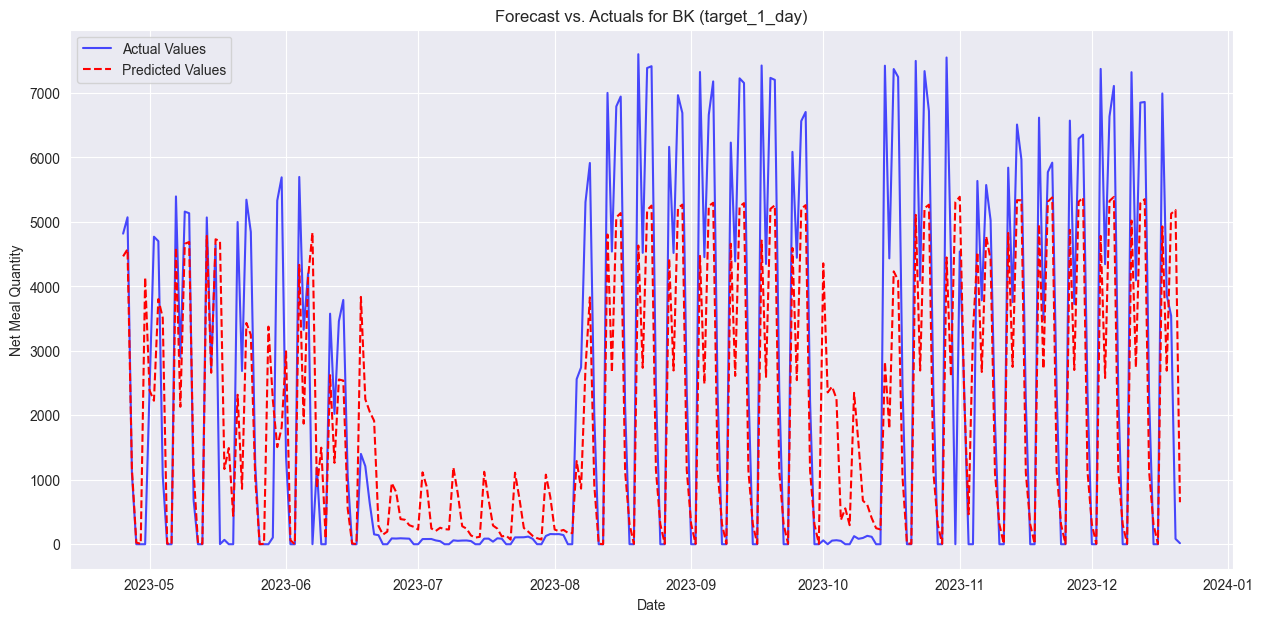


--- End of Step 5 ---


In [46]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 5. MODEL EVALUATION ---
print("\n--- Step 5: Model Evaluation ---")
print("Goal: Assess model performance, keeping in mind the cost of under-prediction.")

# Custom cost function: higher penalty for under-prediction
def asymmetric_loss(y_true, y_pred):
    errors = y_true - y_pred
    # Penalize negative errors (under-predictions) more
    loss = np.where(errors < 0, errors**2 * 1.5, errors**2)
    return np.sqrt(np.mean(loss))

results = []
for site in models:
    for horizon in models[site]:
        model_info = models[site][horizon]
        model = model_info['model']
        X_test = model_info['X_test']
        y_test = model_info['y_test']

        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        custom_loss = asymmetric_loss(y_test, y_pred)

        results.append({
            'Site': site,
            'Horizon': horizon,
            'MAE': mae,
            'RMSE': rmse,
            'Asymmetric_Loss': custom_loss
        })

results_df = pd.DataFrame(results)
print("Forecasting Model Performance:")
print(results_df)


# Visualize predictions for one example
# *** FIX: Dynamically select the first available site to prevent KeyErrors ***
if not models:
    print("No models were trained, skipping visualization.")
else:
    site_to_plot = list(models.keys())[0]
    horizon_to_plot = 'target_1_day'

    model_info = models[site_to_plot][horizon_to_plot]
    y_test = model_info['y_test']
    y_pred = model_info['model'].predict(model_info['X_test'])

    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='Actual Values', color='blue', alpha=0.7)
    plt.plot(y_test.index, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Forecast vs. Actuals for {site_to_plot} ({horizon_to_plot})')
    plt.xlabel('Date')
    plt.ylabel('Net Meal Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n--- End of Step 5 ---")



In [49]:
# show worst predications
temp_df = model_info['X_test'].copy()
temp_df['y_true'] = y_test
temp_df['y_pred'] = y_pred
temp_df['error'] = np.abs(temp_df['y_true'] - temp_df['y_pred'])
temp_df.sort_values(by='error', ascending=False)


,day_of_year,weekday,is_weekend,month,quarter,day_of_month,sin_doy,cos_doy,is_holiday,lag_1,...,lag_7,lag_14,rolling_mean_7,rolling_mean_14,site_lag_1,site_lag_7,site_rolling_mean_7,y_true,y_pred,error
2023-10-31,304,1,False,10,4,31,-0.869233,0.494403,0,4822.000000,...,2743.666667,2910.666667,2711.857143,2739.238095,7550.0,4089.0,4011.142857,0.0,5305.804351,5305.804351
2023-12-20,354,2,False,12,4,20,-0.192322,0.981332,0,2605.666667,...,4558.333333,4540.000000,2595.380952,2632.619048,3863.0,6850.0,3835.714286,83.0,5184.106270,5101.106270
2023-06-07,158,2,False,6,2,7,0.411054,-0.911611,0,2245.000000,...,3922.000000,4068.000000,2215.571429,1840.309524,3326.0,5330.0,3058.000000,0.0,4833.862800,4833.862800
2023-05-17,137,2,False,5,2,17,0.706727,-0.707487,1,2252.000000,...,3870.000000,3839.333333,2179.666667,2188.785714,2727.0,5160.0,2682.857143,1.0,4703.268653,4702.268653
2023-10-15,288,6,True,10,4,15,-0.970882,0.239557,0,0.000000,...,0.000000,0.000000,513.523810,427.357143,0.0,0.0,78.714286,7423.0,2828.237311,4594.762689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-26,146,4,False,5,2,26,0.589176,-0.808005,0,3834.000000,...,200.333333,1383.000000,1985.619048,1781.952381,4844.0,68.0,2563.000000,0.0,0.932854,0.932854
2023-08-12,224,5,True,8,3,12,-0.653160,-0.757220,0,1792.000000,...,0.000000,0.333333,1833.047619,1113.095238,1999.0,0.0,2646.000000,0.0,0.499343,0.499343
2023-06-03,154,5,True,6,2,3,0.472759,-0.881192,0,1491.000000,...,22.333333,0.333333,1446.047619,1816.952381,1362.0,0.0,1783.857143,0.0,0.046986,0.046986
2023-06-17,168,5,True,6,2,17,0.248940,-0.968519,0,1252.666667,...,0.000000,0.000000,1600.571429,1534.190476,1064.0,0.0,1987.285714,0.0,0.034408,0.034408


In [50]:

# --- 6. GENERATING FUTURE FORECASTS ---
print("\n--- Step 6: Generating Future Forecasts ---")
print("Goal: Use the trained models to predict meal counts for upcoming dates.")

# To make future predictions, we need to create the feature set for future dates.
# Let's create features for the next 14 days from the end of our data.
last_date = time_features.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=14, freq='D')

future_features = pd.DataFrame(index=future_dates)
future_features['day_of_year'] = future_features.index.dayofyear
future_features['weekday'] = future_features.index.weekday
future_features['is_weekend'] = future_features.index.weekday >= 5
future_features['month'] = future_features.index.month
future_features['quarter'] = future_features.index.quarter
future_features['day_of_month'] = future_features.index.day
future_features['sin_doy'] = np.sin(2 * np.pi * future_features['day_of_year'] / 365.25)
future_features['cos_doy'] = np.cos(2 * np.pi * future_features['day_of_year'] / 365.25)
future_features['is_holiday'] = np.random.choice([0, 1], size=len(future_features), p=[0.97, 0.03])

print(f"Created feature templates for {len(future_features)} future dates.")

# We need the most recent data to calculate lags and rolling features for the future dates.
# This requires an iterative approach, which is complex. For this example, we'll simplify
# by assuming we can calculate these features. In a production system, you would append
# the prediction for day t+1 to your history to calculate features for day t+2.

# For simplicity, we'll use the last available values for lags.
last_known_features = time_features.iloc[-1]

for col in [c for c in reg_features if c not in future_features.columns]:
     if 'site' not in col: # Don't copy over old site-specific features
        future_features[col] = last_known_features[col]

print("Predicting future demand...")
future_predictions = {}
for site in models:
    future_predictions[site] = {}

    # Add latest site-specific features for prediction
    temp_future_features = future_features.copy()
    temp_future_features['site_lag_1'] = pivot_demand[site].iloc[-1]
    temp_future_features['site_lag_7'] = pivot_demand[site].iloc[-7]
    temp_future_features['site_rolling_mean_7'] = pivot_demand[site].rolling(window=7).mean().iloc[-1]

    for horizon, model_info in models[site].items():
        model = model_info['model']
        # Ensure feature order is the same as during training
        X_future = temp_future_features[model.feature_names_in_]
        predictions = model.predict(X_future)
        future_predictions[site][horizon] = predictions

# Displaying the forecast for the first future day
forecast_day_1 = pd.DataFrame({
    site: {
        horizon: f"{int(preds[0])} meals" for horizon, preds in site_preds.items()
    } for site, site_preds in future_predictions.items()
}).T

print("\nSample Forecast for the next available day:")
print(forecast_day_1)
print("\n--- End of Step 6 ---")


--- Step 6: Generating Future Forecasts ---
Goal: Use the trained models to predict meal counts for upcoming dates.
Created feature templates for 14 future dates.
Predicting future demand...

Sample Forecast for the next available day:
   target_1_day target_2_5_days target_6_10_days
BK    404 meals      1273 meals         88 meals
LP    517 meals      1078 meals        172 meals
MS    604 meals      1011 meals        871 meals

--- End of Step 6 ---


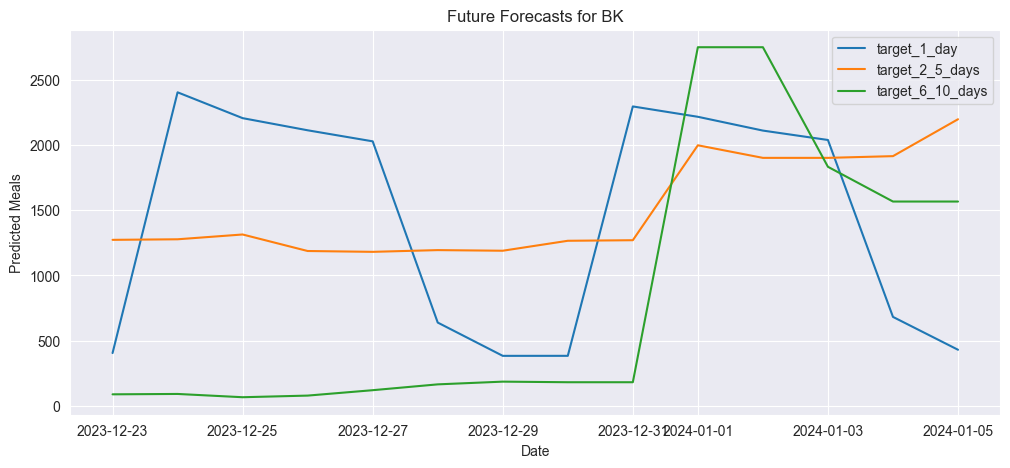

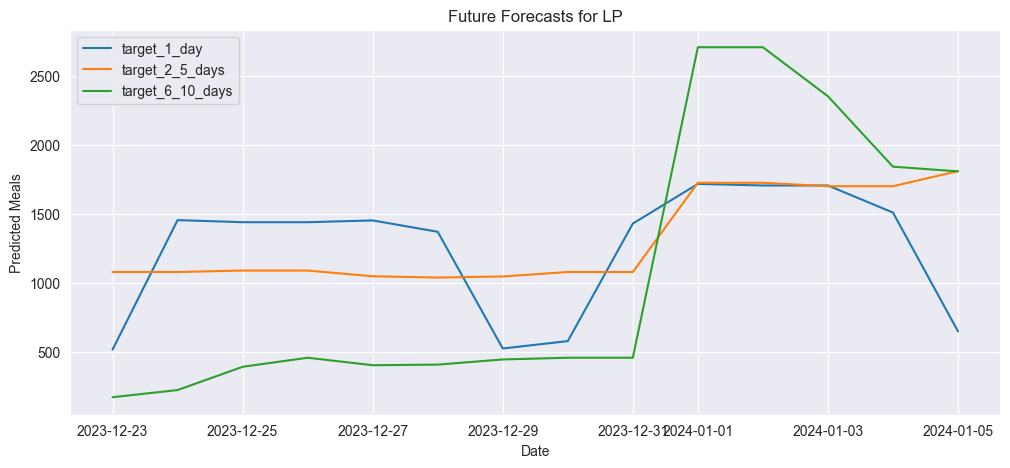

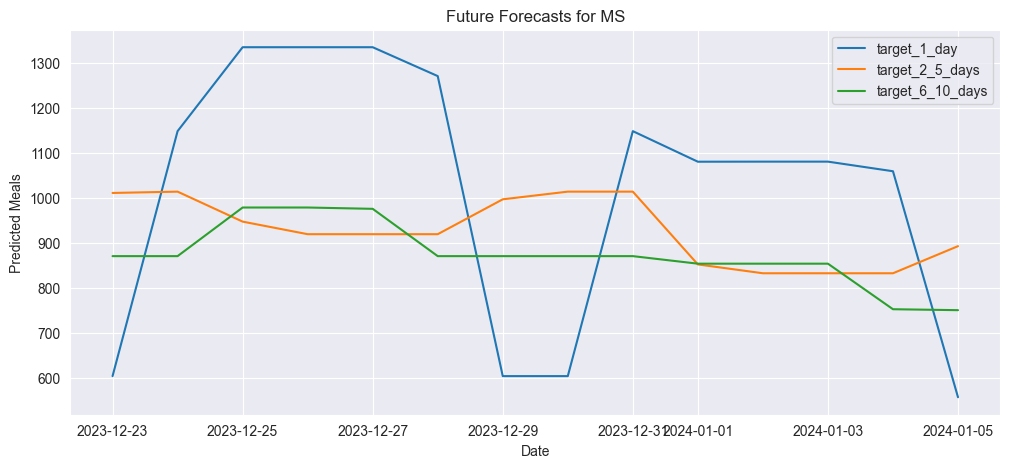

In [51]:
for site in future_predictions:
    plt.figure(figsize=(12, 5))
    for horizon in future_predictions[site]:
        plt.plot(future_dates, future_predictions[site][horizon], label=horizon)
    plt.title(f'Future Forecasts for {site}')
    plt.xlabel('Date')
    plt.ylabel('Predicted Meals')
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:
column_names = df.columns.tolist()

print(column_names)


['DateOfOrder', 'OrderId', 'TransactionId', 'DateOfService', 'OrderQty', 'MenuName', 'MenuPrice', 'MenuSubsidy', 'BookingNr', 'GroupName', 'CanceledQty', 'DateOfCancel', 'Site', 'SchoolID', 'net_qty', 'days_to_cancel', 'MenuNorm', 'MenuBase', 'MenuCode', 'day_of_year', 'weekday', 'is_weekend', 'sin_doy', 'cos_doy', 'cancel_timing', 'subsidy_pct', 'month', 'quarter', 'day_of_month', 'is_month_end', 'is_month_start', 'order_hour', 'morning', 'afternoon', 'evening', 'hist_cancel_rate', 'is_holiday', 'is_canceled']
